# Прогнозирование уровня средней заработной платы в России

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


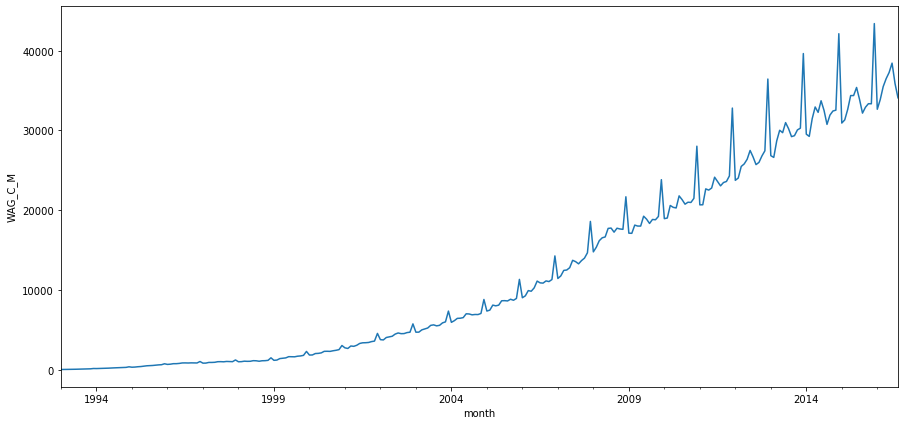

In [2]:
salary = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
salary['WAG_C_M'].plot()
plt.ylabel('WAG_C_M')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

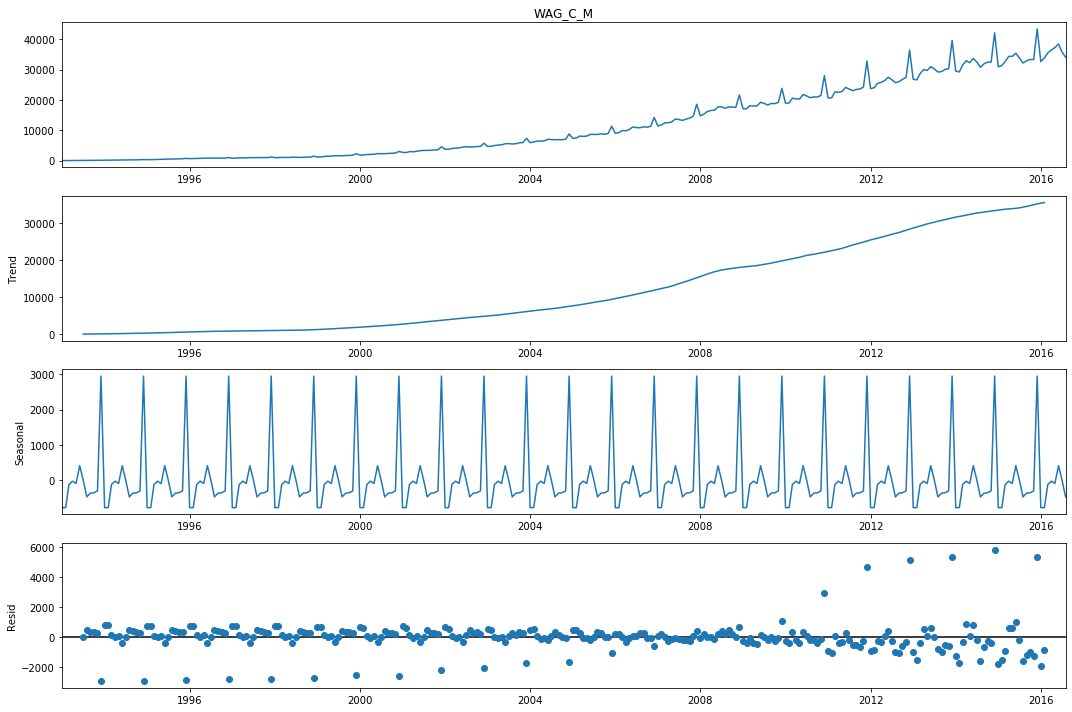

In [3]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary['WAG_C_M']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary['WAG_C_M'])[1])

### Стабилизация дисперсии

По графику ряда видно, что дисперсия в начале и в конце сильно отличаются

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.991850


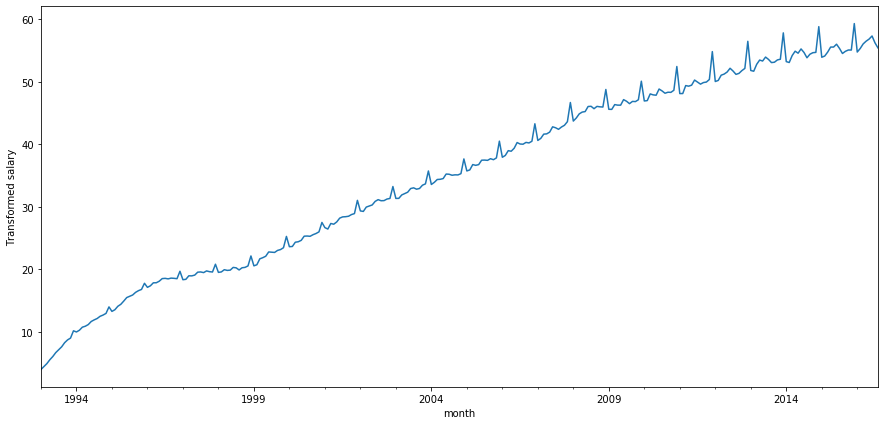

In [4]:
salary['WAG_C_M_box'], lmbda = stats.boxcox(salary['WAG_C_M'])
plt.figure(figsize(15,7))
salary['WAG_C_M_box'].plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary['WAG_C_M'])[1])

### Стационарность

Критерий Дики-Фуллера уверенно не отвергает гипотезу нестационарности, и визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

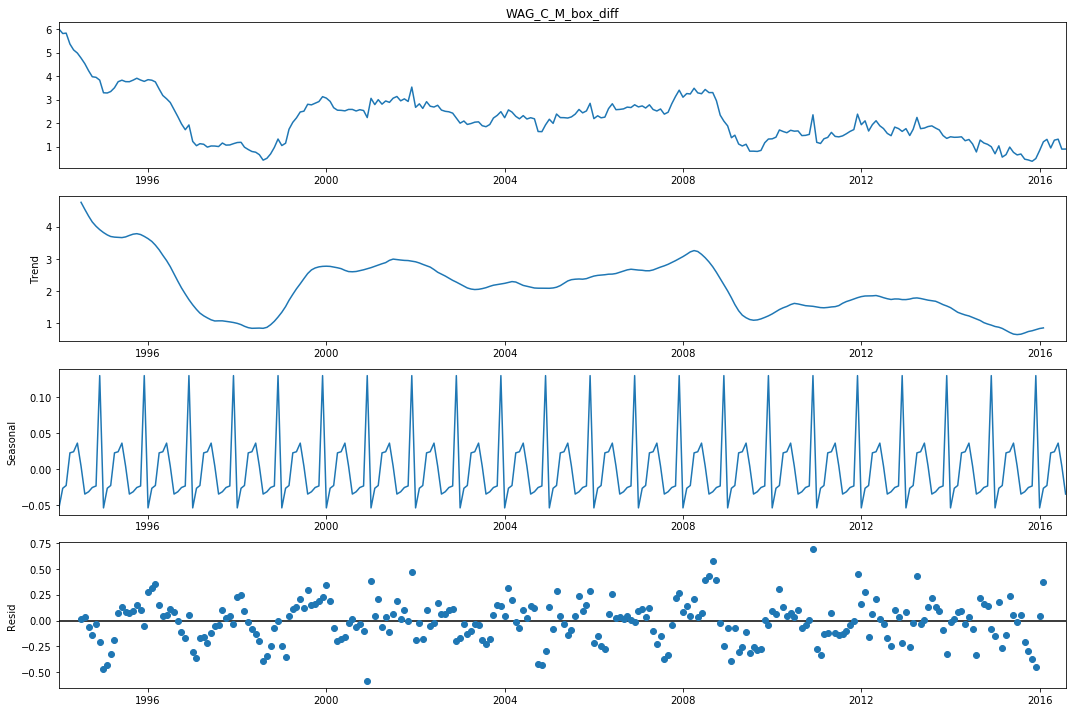

In [5]:
salary['WAG_C_M_box_diff'] = salary['WAG_C_M_box'] - salary['WAG_C_M_box'].shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary['WAG_C_M_box_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary['WAG_C_M_box_diff'][12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

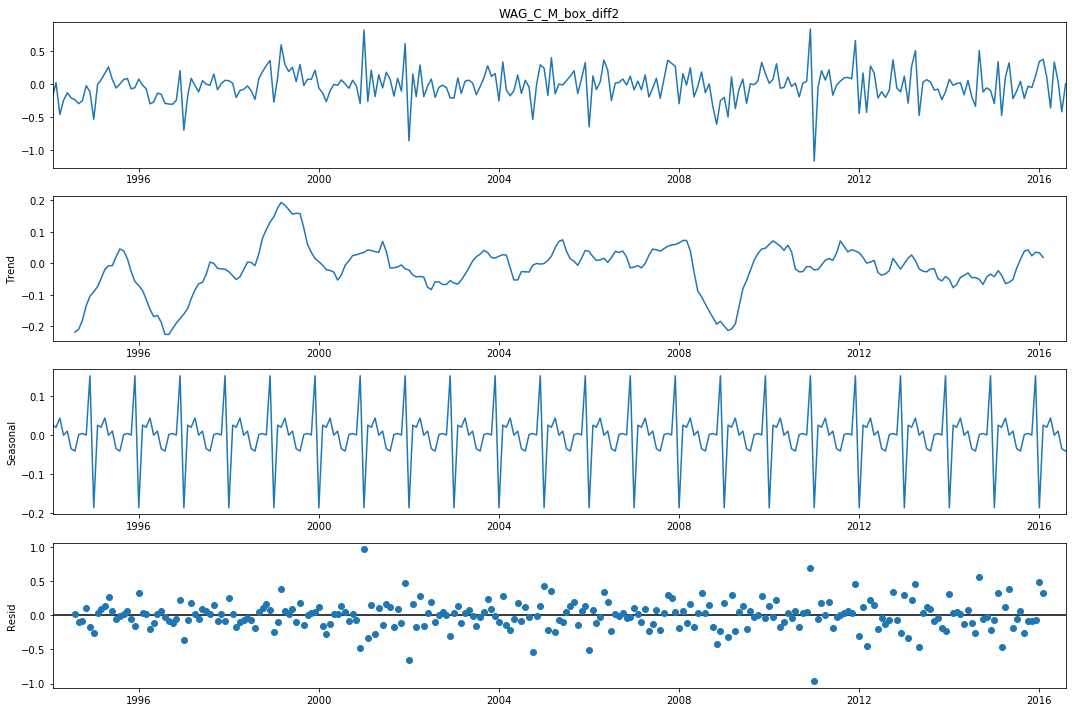

In [6]:
salary['WAG_C_M_box_diff2'] = salary['WAG_C_M_box_diff'] - salary['WAG_C_M_box_diff'].shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary['WAG_C_M_box_diff2'][13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary['WAG_C_M_box_diff2'][13:])[1])

Гипотеза уверенно нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

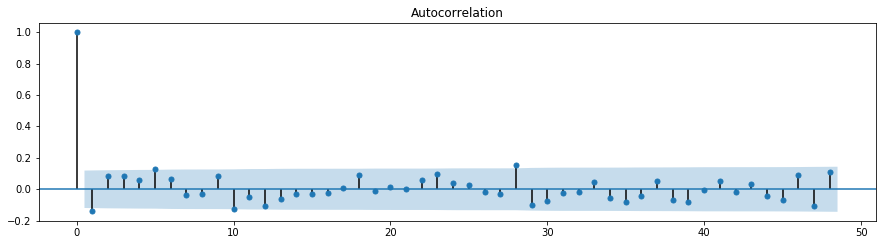

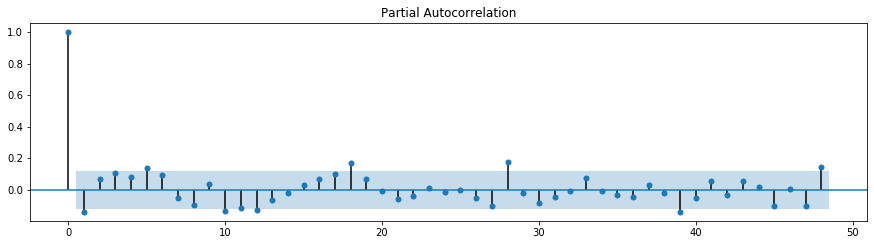

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary['WAG_C_M_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary['WAG_C_M_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=1, P=4, p=2

In [8]:
ps = range(0, 3)
d = 1
qs = range(0, 2)
Ps = range(0, 5)
D = 1
Qs = range(0, 1)

In [9]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

30

In [10]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary['WAG_C_M_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 37.5 s


In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
26  (2, 1, 1, 0) -3.884138
27  (2, 1, 2, 0) -2.455104
29  (2, 1, 4, 0) -1.586114
25  (2, 1, 0, 0) -1.355269
28  (2, 1, 3, 0) -0.639552


Лучшая модель:

In [12]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 12)   Log Likelihood                   6.942
Date:                             Fri, 15 May 2020   AIC                             -3.884
Time:                                     23:38:44   BIC                             14.126
Sample:                                 01-01-1993   HQIC                             3.347
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6049      0.193      3.139      0.002       0.227       0.982
ar.L2          0.2269      

Её остатки:

Критерий Стьюдента: p=0.280940
Критерий Дики-Фуллера: p=0.000000


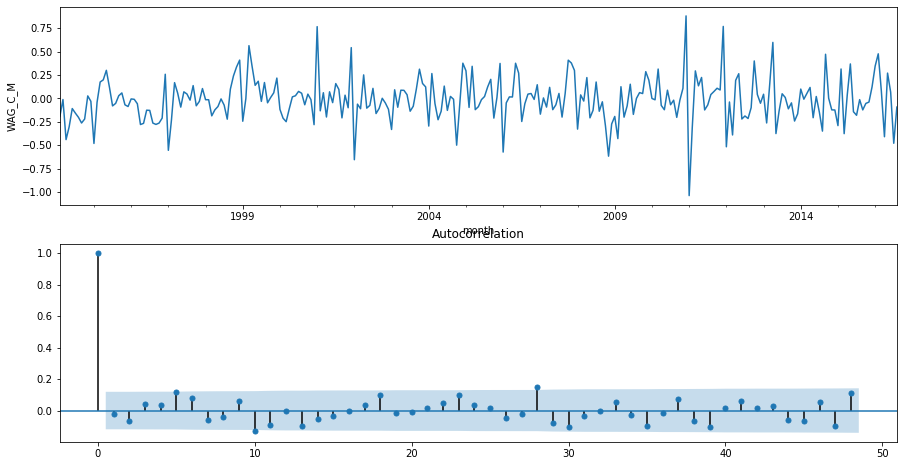

In [13]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'WAG_C_M')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

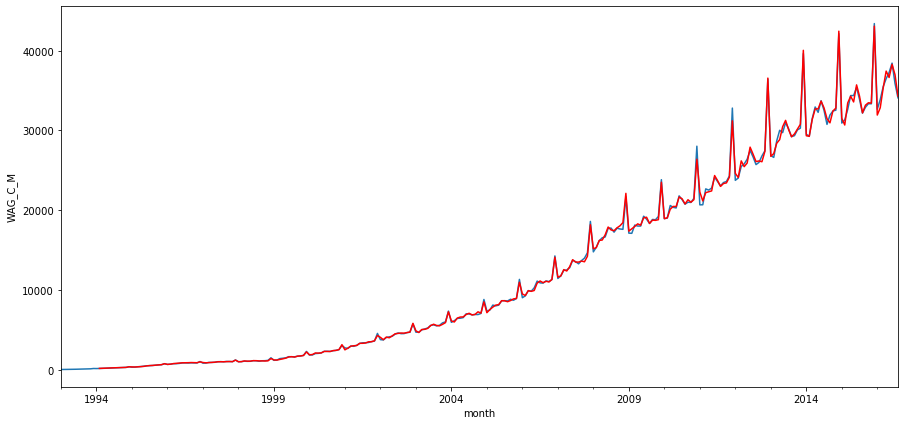

In [19]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary['WAG_C_M'].plot()
salary['model'][13:].plot(color='r')
plt.ylabel('WAG_C_M')
pylab.savefig("prediction.png")
pylab.show()


### Прогноз

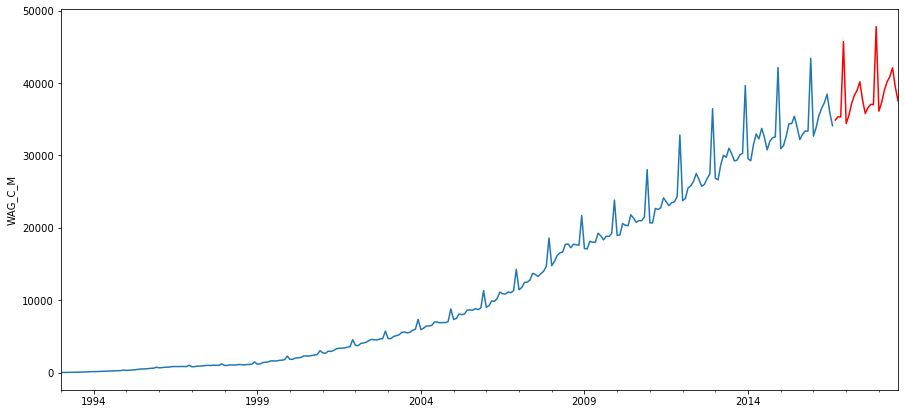

In [21]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbda)

plt.figure(figsize(15,7))
salary2['WAG_C_M'].plot()
salary2['forecast'].plot(color='r')
plt.ylabel('WAG_C_M')
pylab.savefig("future_prediction.png")
pylab.show()